In [1]:
import gmsh
import numpy as np
import jax.numpy as jnp
from dctkit.mesh import util, simplex
from dctkit.math.opt import optctrl
from dctkit.apps.linear_elasticity import LinearElasticity
import dctkit.dec.cochain as C
import dctkit as dt
from matplotlib.pyplot import triplot

In [2]:
dt.config()

In [3]:
lc = 0.5
gmsh.initialize()
gmsh.model.add("t1")
gmsh.model.geo.addPoint(1, 0, 0, lc, 1)
gmsh.model.geo.addPoint(0, 0, 0, lc, 2)
gmsh.model.geo.addPoint(1, 1, 0, lc, 3)
gmsh.model.geo.addPoint(0, 1, 0, lc, 4)

gmsh.model.geo.addLine(1, 2, 1)
gmsh.model.geo.addLine(2, 4, 2)
gmsh.model.geo.addLine(4, 3, 3)
gmsh.model.geo.addLine(3, 1, 4)
gmsh.model.geo.addCurveLoop([1, 2, 3, 4], 1)
gmsh.model.geo.addPlaneSurface([1], 1)
gmsh.model.geo.synchronize()
gmsh.model.addPhysicalGroup(1, [1, 2, 3, 4], 1)
gmsh.model.addPhysicalGroup(1, [2], 2, name="left")
gmsh.model.addPhysicalGroup(1, [4], 3, name="right")
gmsh.model.mesh.generate(2)

num_nodes, num_elements, S_2, node_coords, bnd_faces_tags = util.read_mesh()
left_bnd_nodes_idx, _ = gmsh.model.mesh.getNodesForPhysicalGroup(1, 2)
right_bnd_nodes_idx, _ = gmsh.model.mesh.getNodesForPhysicalGroup(1, 3)
left_bnd_nodes_idx -= 1
right_bnd_nodes_idx -= 1
# makes concatenation easier when assigning bcs
left_bnd_nodes_idx = list(left_bnd_nodes_idx)
right_bnd_nodes_idx = list(right_bnd_nodes_idx)
print(left_bnd_nodes_idx, right_bnd_nodes_idx)

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 50%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.000225885s, CPU 0.000212s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.00025754s, CPU 0.000256s)
Info    : 12 nodes 26 elements
[1, 3, 5] [0, 2, 7]


In [4]:
S = simplex.SimplicialComplex(S_2, node_coords, bnd_faces_tags=bnd_faces_tags, is_well_centered=True)
S.get_circumcenters()
S.get_primal_volumes()
S.get_dual_volumes()
S.get_hodge_star()
S.get_dual_edge_vectors()
S.get_flat_weights()

In [5]:
mu_ = 1.
lambda_ = 10.
ni = lambda_/(2*(mu_ + lambda_))
ela = LinearElasticity(S=S, mu_=mu_, lambda_=lambda_)
gamma = 1000.

left_bnd_nodes_pos = S.node_coord[left_bnd_nodes_idx, :]
right_bnd_nodes_pos = S.node_coord[right_bnd_nodes_idx, :]
right_bnd_nodes_pos[:,0] *= 1.1
print(left_bnd_nodes_pos)
num_faces = S.S[2].shape[0]
embedded_dim = S.embedded_dim
#clamped_bnd_pos = np.vstack((left_bnd_nodes_pos,right_bnd_nodes_pos))
#clamped_bnd_idx = left_bnd_nodes_idx + right_bnd_nodes_idx
clamped_bnd_pos = left_bnd_nodes_pos
clamped_bnd_idx = left_bnd_nodes_idx

[[0.  0.  0. ]
 [0.  1.  0. ]
 [0.  0.5 0. ]]


In [13]:
f = np.zeros((num_faces, (embedded_dim-1)))
f[[0, 5], 1] = 0.25*np.ones(2)
f[[1, 7], 1] = -0.25*np.ones(2)
f[[2, 4], 0] = -0.4*np.ones(2)
f[[3, 6], 0] = 0.4*np.ones(2)
f_flattened = f.flatten()
node_coords_flattened = S.node_coord.flatten()
#boundary_values = (clamped_bnd_idx, clamped_bnd_pos)
boundary_values = {"0": ([3, 5], S.node_coord[[3, 5], :][:, 0]),
                       ":": ([1], S.node_coord[[1], :])}
print(boundary_values)

idx_tractions = jnp.array([0, 1, 3, 4, 6, 7, 9, 10])
bnd_tractions_values = jnp.zeros((8, 2), dtype=dt.float_dtype)
boundary_tractions = (idx_tractions, bnd_tractions_values)

obj_args = {'f': f_flattened, 'gamma': gamma, 'boundary_values': boundary_values, 
            'boundary_tractions': boundary_tractions}

prb = optctrl.OptimizationProblem(dim=S.node_coord.size,
                                  state_dim=S.node_coord.size,
                                  objfun=ela.obj_linear_elasticity)

{'0': ([3, 5], array([0., 0.])), ':': ([1], array([[0., 0., 0.]]))}


In [14]:
prb.set_obj_args(obj_args)
sol = prb.run(x0=node_coords_flattened)
curr_node_coords = sol.reshape(S.node_coord.shape)
print(prb.last_opt_result)

3


In [15]:
strain = ela.get_strain(curr_node_coords)
stress = ela.get_stress(strain)
# print("curr_metric=", S.get_current_metric_2D(curr_node_coords))
print("strain=", strain)
print("stress=", stress)

strain= [[[ 1.04548369e-01 -1.54633986e-06]
  [-1.54633986e-06 -4.54589630e-02]]

 [[ 1.04549993e-01  2.92109808e-06]
  [ 2.92109808e-06 -4.54589800e-02]]

 [[ 1.04556627e-01  3.02018443e-06]
  [ 3.02018443e-06 -4.54658124e-02]]

 [[ 1.04546311e-01 -3.29582968e-06]
  [-3.29582968e-06 -4.54533154e-02]]

 [[ 1.04545850e-01  5.57006961e-07]
  [ 5.57006961e-07 -4.54542798e-02]]

 [[ 1.04549529e-01 -5.17360939e-07]
  [-5.17360939e-07 -4.54601080e-02]]

 [[ 1.04539133e-01 -5.18299166e-06]
  [-5.18299166e-06 -4.54458855e-02]]

 [[ 1.04548594e-01 -6.27344228e-06]
  [-6.27344228e-06 -4.54575284e-02]]

 [[ 1.04555859e-01 -2.44213093e-06]
  [-2.44213093e-06 -4.54609431e-02]]

 [[ 1.04553254e-01 -3.54676654e-06]
  [-3.54676654e-06 -4.54636542e-02]]

 [[ 1.04550049e-01 -9.23925890e-06]
  [-9.23925890e-06 -4.54568085e-02]]

 [[ 1.04553386e-01 -1.22937099e-06]
  [-1.22937099e-06 -4.54621443e-02]]

 [[ 1.04554255e-01 -6.97644916e-06]
  [-6.97644916e-06 -4.54653437e-02]]

 [[ 1.04544630e-01 -5.75427597

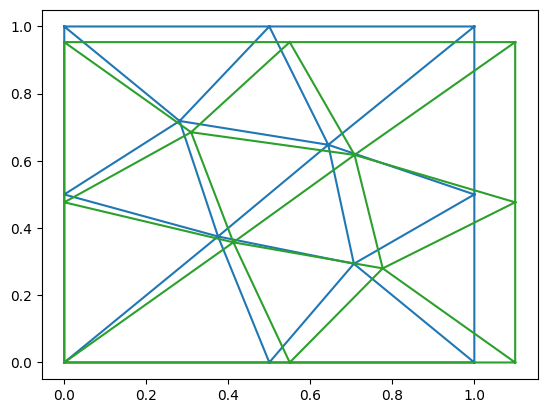

In [16]:
triplot(node_coords[:,0], node_coords[:,1], triangles=S_2)
triplot(curr_node_coords[:,0], curr_node_coords[:,1], triangles=S_2)

In [17]:
from dctkit.dec import vector as V
stress_tensor = V.DiscreteTensorFieldD(S=S, coeffs=stress.T, rank=2)
stress_integrated = V.flat_DPD(stress_tensor)
forces = C.star(stress_integrated)
forces.coeffs

Array([[ 6.27344228e-06, -2.49997802e-01],
       [-4.00005368e-01,  5.18299166e-06],
       [-2.34999364e-01, -1.46876967e-01],
       [ 2.92109808e-06,  2.49996084e-01],
       [-4.00010700e-01, -3.02018443e-06],
       [-3.00003681e-01,  1.87491901e-01],
       [ 1.54633986e-06, -2.49988066e-01],
       [ 4.00011286e-01, -3.29582968e-06],
       [ 2.81670797e-01, -1.78126683e-01],
       [ 4.00003701e-01,  5.57006961e-07],
       [-5.17360939e-07,  2.49986999e-01],
       [ 2.25000106e-01,  1.40622359e-01],
       [-2.35003852e-01,  1.03125014e-01],
       [-3.00003269e-01, -6.24990283e-02],
       [ 1.00003922e-01,  1.87492919e-01],
       [-1.75002740e-01,  1.40624939e-01],
       [ 2.81671117e-01,  7.18727193e-02],
       [ 2.25006201e-01, -1.09374649e-01],
       [ 1.65003037e-01, -1.46882396e-01],
       [-1.18331808e-01, -1.78127300e-01],
       [-6.49971998e-02, -1.65621735e-01],
       [-2.83334594e-01, -3.12446973e-02],
       [-2.18341495e-01,  1.34375864e-01],
       [-2.

In [18]:
print(curr_node_coords)
node_coord_final = node_coords.copy()
node_coord_final[:,0] *= 1.1
node_coord_final[:,1] *= (1-0.1*ni)
print(node_coord_final)
print(np.sum((node_coord_final - curr_node_coords)**2))

[[ 1.09959020e+00 -1.27732597e-05  0.00000000e+00]
 [ 1.36088220e-08 -3.69525972e-09  0.00000000e+00]
 [ 1.09958988e+00  9.53455002e-01  0.00000000e+00]
 [ 7.56463168e-09  9.53456816e-01  0.00000000e+00]
 [ 5.49795427e-01 -4.24018130e-07  0.00000000e+00]
 [ 1.79173138e-08  4.76725382e-01  0.00000000e+00]
 [ 5.49795210e-01  9.53454356e-01  0.00000000e+00]
 [ 1.09959090e+00  4.76723063e-01  0.00000000e+00]
 [ 7.76588712e-01  2.80073198e-01  0.00000000e+00]
 [ 4.12348839e-01  3.57546408e-01  0.00000000e+00]
 [ 7.07862564e-01  6.17757887e-01  0.00000000e+00]
 [ 3.09258874e-01  6.85295720e-01  0.00000000e+00]]
[[1.1        0.         0.        ]
 [0.         0.         0.        ]
 [1.1        0.95454545 0.        ]
 [0.         0.95454545 0.        ]
 [0.55       0.         0.        ]
 [0.         0.47727273 0.        ]
 [0.55       0.95454545 0.        ]
 [1.1        0.47727273 0.        ]
 [0.776875   0.28039773 0.        ]
 [0.4125     0.35795455 0.        ]
 [0.708125   0.61846591 0. 

In [19]:
strain = ela.get_strain(node_coord_final)
stress = ela.get_stress(strain)
print("strain=", strain)
print("stress=", stress)

strain= [[[ 1.05000000e-01 -1.41830993e-17]
  [-1.40997756e-17 -4.44214876e-02]]

 [[ 1.05000000e-01 -2.85201927e-17]
  [-5.62757683e-17 -4.44214876e-02]]

 [[ 1.05000000e-01  1.22679644e-16]
  [ 1.39924804e-17 -4.44214876e-02]]

 [[ 1.05000000e-01 -7.41901651e-17]
  [-9.57007362e-17 -4.44214876e-02]]

 [[ 1.05000000e-01 -4.13558081e-17]
  [ 1.52933221e-16 -4.44214876e-02]]

 [[ 1.05000000e-01 -2.27012222e-16]
  [-2.14474901e-17 -4.44214876e-02]]

 [[ 1.05000000e-01  6.12287994e-17]
  [ 8.49813790e-17 -4.44214876e-02]]

 [[ 1.05000000e-01 -1.77126682e-16]
  [-1.14052136e-16 -4.44214876e-02]]

 [[ 1.05000000e-01  1.93289490e-16]
  [ 1.12848939e-16 -4.44214876e-02]]

 [[ 1.05000000e-01 -6.48529935e-17]
  [ 9.16205393e-19 -4.44214876e-02]]

 [[ 1.05000000e-01  6.45611219e-17]
  [ 1.14840151e-16 -4.44214876e-02]]

 [[ 1.05000000e-01  2.19824164e-17]
  [-5.41348426e-18 -4.44214876e-02]]

 [[ 1.05000000e-01  7.86248669e-17]
  [ 1.16380187e-16 -4.44214876e-02]]

 [[ 1.05000000e-01  4.12581374